In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm

from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import util.df_enricher as jn
import util.jndb as db

In [2]:
ratings = jn.get_enriched_card_ratings()
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77809 entries, 0 to 77808
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   syllabus_name     77809 non-null  category      
 1   subject_name      77809 non-null  category      
 2   chapter_id        77809 non-null  int64         
 3   chapter_name      77809 non-null  object        
 4   card_id           77809 non-null  int64         
 5   card_type         77809 non-null  category      
 6   difficulty_level  77809 non-null  int64         
 7   timestamp         77809 non-null  datetime64[ns]
 8   time_spent        77809 non-null  int64         
 9   rating            77809 non-null  category      
 10  prior_le          77809 non-null  float64       
 11  rating_num        77809 non-null  category      
 12  is_correct        77809 non-null  category      
 13  attempt_num       77809 non-null  int64         
 14  gap_duration      7780

In [3]:
# Compute the error percentage across card types.

ct = pd.crosstab( ratings.card_type, ratings.is_correct, margins=True, margins_name='Total' )
err_pct = []
for idx,row in ct.iterrows():
    err_pct.append( (row[0]/row['Total'])*100 )
ct['err_pct'] = err_pct
ct

is_correct,0,1,Total,err_pct
card_type,,,,
fib,5010,35545,40555,12.353594
image_label,20,65,85,23.529412
matching,59,658,717,8.228731
multi_choice,890,7104,7994,11.133350
question_answer,2615,19460,22075,11.845980
true_false,591,5792,6383,9.258969
Total,9185,68624,77809,11.804547


In [4]:
type_ratings = ratings[ratings.card_type == 'question_answer']
type_ratings = type_ratings[type_ratings.attempt_num > 2]
X = type_ratings[['subject_num','difficulty_level','time_spent','attempt_num', 'gap_duration', 'prior_le']]
Y = type_ratings['is_correct']

In [5]:
X.head()

,subject_num,difficulty_level,time_spent,attempt_num,gap_duration,prior_le
2,1,23,19,3,16,87.500000
3,1,23,15,4,27,91.666667
15,1,36,28,3,7,62.500000
16,1,36,21,4,23,75.000000
17,1,36,43,5,28,81.250000


In [6]:
rfe = RFE( estimator=DecisionTreeClassifier(), n_features_to_select=1 )
rfe.fit( X, Y )
print(rfe.feature_names_in_)
print(rfe.support_)
print(rfe.ranking_)

['subject_num' 'difficulty_level' 'time_spent' 'attempt_num'
 'gap_duration' 'prior_le']
[False False  True False False False]
[5 3 1 6 2 4]


In [7]:
logit_model=sm.Logit(Y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.192498
         Iterations 7
                         Results: Logit
Model:               Logit            Method:           MLE      
Dependent Variable:  is_correct       Pseudo R-squared: 0.253    
Date:                2023-11-03 16:17 AIC:              4318.1905
No. Observations:    11185            BIC:              4362.1245
Df Model:            5                Log-Likelihood:   -2153.1  
Df Residuals:        11179            LL-Null:          -2883.4  
Converged:           1.0000           LLR p-value:      0.0000   
No. Iterations:      7.0000           Scale:            1.0000   
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
subject_num       0.0580   0.0125   4.6290 0.0000  0.0335  0.0826
difficulty_level  0.0379   0.0026  14.4576 0.0000  0.0328  0.0430


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [9]:
logreg.coef_

array([[ 0.03298498,  0.03443613, -0.04446876,  0.10606699, -0.004474  ,
         0.02422741]])

In [10]:
logreg.intercept_

array([1.13495364])

In [11]:
y_prob = logreg.predict_proba( X_test )
y_prob

array([[0.00744309, 0.99255691],
       [0.01625078, 0.98374922],
       [0.03296798, 0.96703202],
       ...,
       [0.02342535, 0.97657465],
       [0.0239426 , 0.9760574 ],
       [0.04581361, 0.95418639]])

In [12]:
lrv = np.dot( [2,15,17,2,11,100], logreg.coef_[0] ) + logreg.intercept_
p = 1/(1+np.exp(-lrv))
print( p )

[0.97200018]


In [13]:
# y_pred = logreg.predict(X_test)
y_pred = []
for prob in y_prob:
    y_pred.append( 1 if prob[1] >= 0.8855 else 0 )
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.93


In [14]:
c_mat = confusion_matrix(y_test, y_pred, labels=[0,1])
print(c_mat)

[[ 171   83]
 [ 283 2819]]


<Axes: >

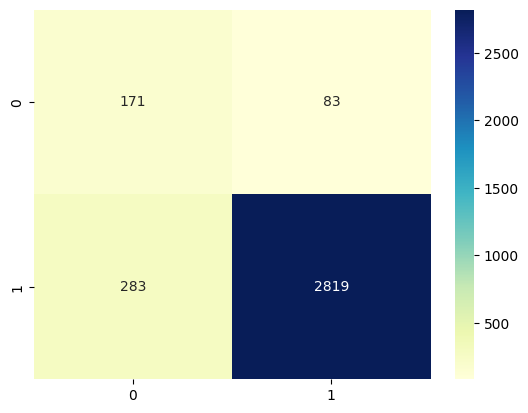

In [15]:
sns.heatmap(pd.DataFrame(c_mat), annot=True, cmap="YlGnBu" ,fmt='g')

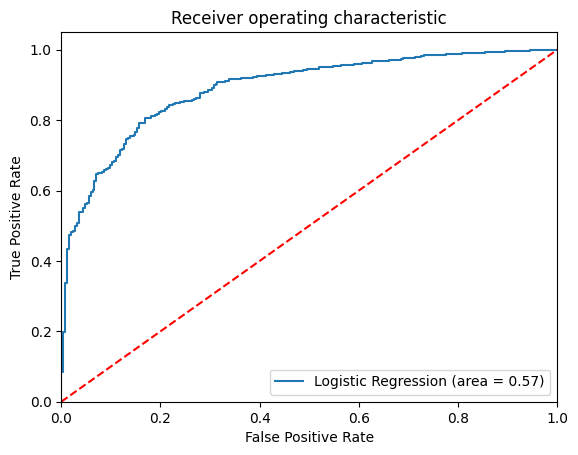

inf, 0.0, 1.0
0.9990265169303145, 0.0003223726627981947, 1.0
0.9883227327032427, 0.0854287556415216, 1.0
0.988254403126132, 0.0854287556415216, 0.9960629921259843
0.98451001605001, 0.16247582205029013, 0.9960629921259843
0.9845040868572474, 0.16312056737588654, 0.9960629921259843
0.9831044560515171, 0.19825918762088976, 0.9960629921259843
0.983102916388462, 0.19825918762088976, 0.9921259842519685
0.9827862922915278, 0.20502901353965183, 0.9921259842519685
0.9827602996436091, 0.20567375886524822, 0.9921259842519685
0.9803598978298043, 0.26595744680851063, 0.9921259842519685
0.9803594477666729, 0.266602192134107, 0.9921259842519685
0.9796407908080697, 0.2846550612508059, 0.9921259842519685
0.9796289391862776, 0.2856221792392005, 0.9921259842519685
0.9794159536083252, 0.2933591231463572, 0.9921259842519685
0.9793973124573916, 0.2940038684719536, 0.9921259842519685
0.979268723159105, 0.29626047711154097, 0.9921259842519685
0.9792470009546147, 0.29690522243713735, 0.9921259842519685
0.97887

In [16]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

for i in range(len(fpr)):
    print( f'{thresholds[i]}, {tpr[i]}, {1-fpr[i]}' )